# 一、读取文本

In [1]:
import pandas as pd
import numpy as np

fake_text = pd.read_csv('DataSet_Misinfo_FAKE.csv').head(50)
real_text = pd.read_csv('DataSet_Misinfo_TRUE.csv').head(50)

fake_text.drop(fake_text.columns[0],axis=1,inplace=True)
real_text.drop(real_text.columns[0],axis=1,inplace=True)

In [2]:
mixed_text = pd.concat([real_text,fake_text])['text'].tolist()

for i in range(0,len(mixed_text)):
    mixed_text[i] = str(mixed_text[i])
    
Y = np.concatenate([np.ones(len(real_text)), np.zeros(len(fake_text))])

# 二、采用BERT进行编码

In [3]:
#对文本进行预处理
import torch
import numpy as np
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')#选用large-cased版本

#tokenize
tokenized_text = tokenizer(mixed_text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')


#构建TensorDataset用于训练
input_ids = tokenized_text['input_ids']
attention_mask = tokenized_text['attention_mask']
Y = torch.tensor(Y)

data = torch.utils.data.TensorDataset(input_ids,attention_mask,Y)


In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_data, test_data = train_test_split(data, test_size=0.2)

train_loaded = DataLoader(train_data, batch_size=32)
test_loaded = DataLoader(test_data, batch_size=32)

In [7]:
from tqdm import tqdm
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-cased')

#定义训练参数
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import os
from torchmetrics.functional import accuracy
from torchmetrics import Recall, F1Score, Precision

os.environ['KMP_DUPLICATE_LIB_OK']='True'

NoneType = type(None)

if torch.cuda.is_available():
    model = model.cuda()
    loss_fn = loss_fn.cuda()

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    model.train()
    
    for batch in tqdm(train_loaded, desc=f"Epoch {epoch + 1}/{epochs}"):
        input_ids, attention_mask, Y = batch
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        
        output = model(input_ids, attention_mask)
        
        logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        acc = accuracy(predictions, Y,'multiclass', num_classes=2)
        precision =  Precision('multiclass',average='micro', num_classes=2)
        pre = precision(predictions, Y)
        f1score =  F1Score('multiclass', num_classes=2)
        f1 = f1score(predictions, Y)
        recall = Recall('multiclass',average='micro', num_classes=2)
        rec = recall(predictions, Y)
    
        Y1=Y.long()
        loss = loss_fn(logits,Y1)
        loss.backward()
        
        optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for valinput_ids, valattention_mask, valY in test_loaded:
                valinput_ids = valinput_ids.squeeze(1).to(device)
                valattention_mask = valattention_mask.to(device)
                valY = valY.to(device)
        
                optimizer.zero_grad()
                output1 = model(valinput_ids, valattention_mask)
            
                logits1 = output1.logits
                predictions1 = torch.argmax(logits1, dim=1)
                acc1 = accuracy(predictions1, valY,'binary', num_classes=2)
                
                precision =  Precision('multiclass',average='micro', num_classes=2)
                pre1 = precision(predictions1, valY)
                f1score =  F1Score('multiclass', num_classes=2)
                f1_1 = f1score(predictions1, valY)
                recall = Recall('multiclass',average='micro', num_classes=2)
                rec1 = recall(predictions1, valY)
                
                optimizer.step()
                
    print(f'''Epochs: {epoch + 1} 
            | Train Accuracy: {acc: .3f}  
            | Train Precision: {pre: .3f} 
            | Train Recall: {rec: .3f} 
            | Train F1Score: {f1: .3f}
            | Val Accuracy: {acc1: .3f}
            | Val Precision: {pre1: .3f}
            | Val Recall: {rec1: .3f}
            | Val F1Score: {f1_1: .3f}''') 

Epoch 1/5: 100%|██████████| 3/3 [02:08<00:00, 43.00s/it]


Epochs: 1 
            | Train Accuracy:  0.750  
            | Train Precision:  0.750 
            | Train Recall:  0.750 
            | Train F1Score:  0.750
            | Val Accuracy:  0.600
            | Val Precision:  0.600
            | Val Recall:  0.600
            | Val F1Score:  0.600


Epoch 2/5: 100%|██████████| 3/3 [02:04<00:00, 41.59s/it]


Epochs: 2 
            | Train Accuracy:  0.875  
            | Train Precision:  0.875 
            | Train Recall:  0.875 
            | Train F1Score:  0.875
            | Val Accuracy:  0.800
            | Val Precision:  0.800
            | Val Recall:  0.800
            | Val F1Score:  0.800


Epoch 3/5: 100%|██████████| 3/3 [02:01<00:00, 40.65s/it]


Epochs: 3 
            | Train Accuracy:  1.000  
            | Train Precision:  1.000 
            | Train Recall:  1.000 
            | Train F1Score:  1.000
            | Val Accuracy:  0.750
            | Val Precision:  0.750
            | Val Recall:  0.750
            | Val F1Score:  0.750


Epoch 4/5: 100%|██████████| 3/3 [02:02<00:00, 40.79s/it]


Epochs: 4 
            | Train Accuracy:  1.000  
            | Train Precision:  1.000 
            | Train Recall:  1.000 
            | Train F1Score:  1.000
            | Val Accuracy:  0.950
            | Val Precision:  0.950
            | Val Recall:  0.950
            | Val F1Score:  0.950


Epoch 5/5: 100%|██████████| 3/3 [02:06<00:00, 42.12s/it]

Epochs: 5 
            | Train Accuracy:  1.000  
            | Train Precision:  1.000 
            | Train Recall:  1.000 
            | Train F1Score:  1.000
            | Val Accuracy:  1.000
            | Val Precision:  1.000
            | Val Recall:  1.000
            | Val F1Score:  1.000


# 三、在全样本上进行验证

In [3]:
import pandas as pd

result1 = pd.DataFrame({'Epoch' : ['Epoch1','Epoch2','Epoch3','Epoch4','Epoch5'],
                        'Train_Accuracy':[0.75,0.875,1,1,1],
                        'Val_Accuracy':[0.6,0.8,0.75,1,1]})

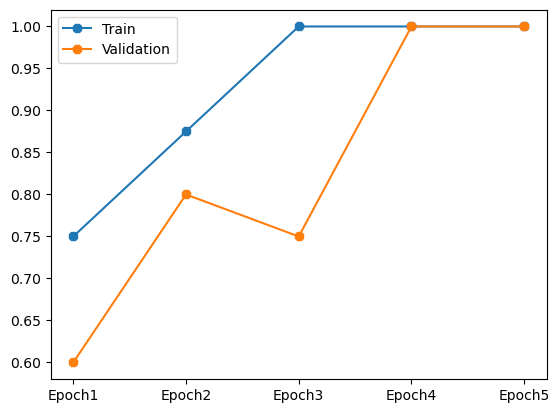

In [15]:
import matplotlib.pyplot as plt

plt.plot(result1['Epoch'],result1['Train_Accuracy'],marker='8', label='Train')
plt.plot(result1['Epoch'],result1['Val_Accuracy'],marker='8', label='Validation')
plt.legend()
plt.show()

In [17]:
mixed_text_all = pd.concat([real_text_all,fake_text_all])['text'].tolist()

for i in range(0,len(mixed_text_all)):
    mixed_text_all[i] = str(mixed_text_all[i])
    
Y_all = np.concatenate([np.ones(len(real_text_all)), np.zeros(len(fake_text_all))])

In [19]:
tokenized_text_all = tokenizer(mixed_text_all, padding='max_length', truncation=True, max_length=512, return_tensors='pt')


#构建TensorDataset用于训练
input_ids_all = tokenized_text_all['input_ids']
attention_mask_all = tokenized_text_all['attention_mask']
Y_all = torch.tensor(Y_all)

data_all = torch.utils.data.TensorDataset(input_ids_all,attention_mask_all,Y_all)

In [20]:
valdata_all = DataLoader(data_all, batch_size=32)

In [ ]:
for allinput_ids, allattention_mask, allY in tqdm(valdata_all):
    allinput_ids = allinput_ids.squeeze(1).to(device)
    allattention_mask = allattention_mask.to(device)
    allY = allY.to(device)
        
    optimizer.zero_grad()
    output_all = model(allinput_ids, allattention_mask)
            
    logits_all = output_all.logits
    predictions_all = torch.argmax(logits_all, dim=1)
    acc_all = accuracy(predictions_all, allY,'binary', num_classes=2)
                
    precision =  Precision('multiclass',average='micro', num_classes=2)
    pre_all = precision(predictions_all, allY)
    f1score =  F1Score('multiclass', num_classes=2)
    f1_all = f1score(predictions_all, allY)
    recall = Recall('multiclass',average='micro', num_classes=2)
    rec_all = recall(predictions_all, allY)

print(f'''| All-text Accuracy: {acc_all: .3f}  
          | All-text Precision: {pre_all: .3f} 
          | All-text Recall: {rec_all: .3f} 
          | All-text F1Score: {f1_all: .3f}''') 

  0%|          | 0/2457 [00:00<?, ?it/s]